# Figure 5: Additional CDR Requirements

In [1]:
import pyam 
import matplotlib.pyplot as plt 
from pathlib import Path 
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import string 

plt.style.use(
    "plotting_template.mplstyle"
)

<IPython.core.display.Javascript object>

# Read in the necessary data

In [2]:
data_folder = Path(
    "..", "data"
)

In [3]:
data_file = Path(
    data_folder / "AR6_Scenarios_Snapshot.xlsx"
)

In [4]:
df_ar6 = pyam.IamDataFrame(data_file)

pyam.core - INFO: Reading file ../data/AR6_Scenarios_Snapshot.xlsx


In [5]:
meta_file = Path(
    data_folder / "AR6_Scenarios_Updated_Meta.xlsx"
)

In [6]:
df_ar6.load_meta(meta_file)

We filter and keep the C1 scenarios.

In [7]:
df_c1 = df_ar6.filter(
    Category_rolling_mean = "C1",
    year = range(2010, 2105,5)
)

In [8]:
df_c1.interpolate(
    time = range(2015, 2105, 5),
    inplace = True
)

# Check if all scenarios report carbon sequestration from land use emissions

In [9]:
cs_variables_to_check = [ 
    "Carbon Sequestration|CCS|Biomass",
    "Carbon Sequestration|Land Use"
]

In [10]:
for var in cs_variables_to_check:
    df_c1.filter(category_new_rolling_mean = "PA*").require_data(variable=var)

We check which scenarios do not report land use sequestration.

In [11]:
df_c1.filter(category_new_rolling_mean = "PA*").require_data(variable=var, exclude_on_fail=True)

pyam.validation - INFO: 12 scenarios failed validation and will be set as `exclude=True`.


model                   scenario  \
0             AIM/CGE 2.1       CD-LINKS_NPi2020_400   
1      AIM/Hub-Global 2.0                       1.5C   
2             POLES EMF33          EMF33_WB2C_nofuel   
3              REMIND 1.7     ADVANCE_2020_1.5C-2100   
4              REMIND 2.1       CEMICS_GDPgrowth_1p5   
5              REMIND 2.1  CEMICS_HotellingConst_1p5   
6              REMIND 2.1          CEMICS_Linear_1p5   
7              REMIND 2.1        R2p1_SSP1-PkBudg900   
8              REMIND 2.1        R2p1_SSP5-PkBudg900   
9       REMIND-MAgPIE 1.5                    SSP2-19   
10  REMIND-MAgPIE 1.7-3.0          EMF33_1.5C_nofuel   
11      WITCH-GLOBIOM 3.1                    SSP4-19   

                         variable  
0   Carbon Sequestration|Land Use  
1   Carbon Sequestration|Land Use  
2   Carbon Sequestration|Land Use  
3   Carbon Sequestration|Land Use  
4   Carbon Sequestration|Land Use  
5   Carbon Sequestration|Land Use  
6   Carbon Sequestration|Land Use  
7   Carbon Sequestration|Land Use  
8   Carbon Sequestration|Land Use  
9   Carbon Sequestration|Land Use  
10  Carbon Sequestration|Land Use  
11  Carbon Sequestration|Land Use

11 out of 29 scenarios do not report carbon sequestration from land use separately. To be consistent, we use the net emissions from AFOLU.

In [12]:
df_c1_nzero = df_c1.filter(netzero = True)

In [13]:
co2_afolu = (
    df_c1_nzero
    .filter(variable = "Emissions|CO2|AFOLU")
    .timeseries()
)

In [14]:
co2_afolu_nn = co2_afolu.applymap(lambda x: -min(x,0)).reset_index()
co2_afolu_nn.variable = "Carbon Sequestration|AFOLU"

/var/folders/nz/kr7bwztj0_d9xrfz1jd4zcdh0000gp/T/ipykernel_5589/2636368026.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  co2_afolu_nn = co2_afolu.applymap(lambda x: -min(x,0)).reset_index()


In [15]:
co2_afolu_nn_pyam = pyam.IamDataFrame(co2_afolu_nn)

Diagnostic check: Check that all these quantiles are positive

In [16]:
co2_afolu_nn_pyam.validate(
    criteria = {"Carbon Sequestration|AFOLU": {"lo": 0}}
)

In [17]:
df_c1_nzero.append( 
    co2_afolu_nn_pyam, 
    inplace = True 
)

# Aggregate non-CO2 emissions

In [18]:
kyoto_gases_excl_co2 = [ 
    "Emissions|N2O",
    "Emissions|CH4",
    "Emissions|SF6",
    "Emissions|HFC|HFC125",
    "Emissions|HFC|HFC134a",
    "Emissions|HFC|HFC143a",
    "Emissions|HFC|HFC227ea",
    "Emissions|HFC|HFC23",
    "Emissions|HFC|HFC32",
    "Emissions|HFC|HFC245fa",
    "Emissions|HFC|HFC43-10",
    "Emissions|PFC|C2F6",
    "Emissions|PFC|C6F14",
    "Emissions|PFC|CF4",
    'Emissions|C2F6',
    'Emissions|CF4'       
]

In [19]:
for variable in kyoto_gases_excl_co2:
    df_c1_nzero.require_data(variable)

Now, we are in a bit of a pickle. So, we use the harmonised F-gas trajectories that are infilled where not available.

In [20]:
kyoto_gases_excl_co2 = [
    "Emissions|CH4",
    "Emissions|N2O",
    "AR6 climate diagnostics|Infilled|Emissions|F-Gases"
]

In [21]:
kyotoghg_excl_co2 = df_c1_nzero.filter(
    variable = kyoto_gases_excl_co2
)

In [22]:
kyotoghg_excl_co2.unit_mapping

{'AR6 climate diagnostics|Infilled|Emissions|F-Gases': 'Mt CO2/yr',
 'Emissions|CH4': 'Mt CH4/yr',
 'Emissions|N2O': 'kt N2O/yr'}

In [23]:
kyotoghg_excl_co2.convert_unit(
    current = "Mt CH4/yr",
    to = "Mt CO2-equiv/yr",
    context = "AR6GWP100",
    inplace=True
)

In [24]:
kyotoghg_excl_co2.convert_unit(
    current = "Mt N2O/yr",
    to = "Mt CO2-equiv/yr",
    context = "AR6GWP100",
    inplace=True
)

In [25]:
kyotoghg_excl_co2.convert_unit(
    current = "kt N2O/yr",
    to = "Mt CO2-equiv/yr",
    context = "AR6GWP100",
    inplace=True
)

In [26]:
kyotoghg_excl_co2.rename(
    unit = {"Mt CO2-equiv/yr": "Mt CO2/yr"},
    inplace = True
)

In [27]:
kyotoghg_excl_co2.interpolate(
    time = range(2010, 2105,5),
    inplace = True
)

In [28]:
kyotoghg_excl_co2.aggregate(
    variable = "Emissions|KyotoGHG|excl. CO2",
    components = kyoto_gases_excl_co2,
    append = True
)

In [29]:
df_c1_nzero.append(
    kyotoghg_excl_co2.filter(
        variable = "Emissions|KyotoGHG|excl. CO2",
        year = range(2010, 2105,5)
    ),
    inplace = True
)

In [30]:
df_c1_nzero.filter(
    category_new_rolling_mean="PA (Art 2 and 4)"
).require_data("Emissions|KyotoGHG|excl. CO2")

model                   scenario  \
0             AIM/CGE 2.1       CD-LINKS_NPi2020_400   
1      AIM/Hub-Global 2.0                       1.5C   
2           C-ROADS-5.005    Ratchet-1.5-limCDR-noOS   
3               IMAGE 3.2         SSP1_SPA1_19I_D_LB   
4               IMAGE 3.2           SSP1_SPA1_19I_LI   
5               IMAGE 3.2      SSP1_SPA1_19I_LIRE_LB   
6               IMAGE 3.2        SSP1_SPA1_19I_RE_LB   
7               IMAGE 3.2            SSP2_SPA2_19I_D   
8               IMAGE 3.2           SSP2_SPA2_19I_LI   
9               IMAGE 3.2         SSP2_SPA2_19I_LIRE   
10    MESSAGE-GLOBIOM 1.0                    SSP2-19   
11          POLES ADVANCE     ADVANCE_2020_1.5C-2100   
12            POLES EMF33          EMF33_WB2C_nofuel   
13             REMIND 1.7     ADVANCE_2020_1.5C-2100   
14             REMIND 1.7           CEMICS-1.5-CDR12   
15             REMIND 1.7           CEMICS-1.5-CDR20   
16             REMIND 1.7            CEMICS-1.5-CDR8   
17             REMIND 2.1       CEMICS_GDPgrowth_1p5   
18             REMIND 2.1  CEMICS_HotellingConst_1p5   
19             REMIND 2.1          CEMICS_Linear_1p5   
20             REMIND 2.1        R2p1_SSP1-PkBudg900   
21             REMIND 2.1        R2p1_SSP5-PkBudg900   
22      REMIND-MAgPIE 1.5                    SSP2-19   
23  REMIND-MAgPIE 1.7-3.0       CD-LINKS_NPi2020_400   
24  REMIND-MAgPIE 1.7-3.0          EMF33_1.5C_nofuel   
25  REMIND-MAgPIE 1.7-3.0          PEP_1p5C_full_eff   
26  REMIND-MAgPIE 1.7-3.0           PEP_1p5C_red_eff   
27  REMIND-MAgPIE 2.1-4.2   CEMICS_SSP1-1p5C-fullCDR   
28  REMIND-MAgPIE 2.1-4.2      SusDev_SDP-PkBudg1000   
29  REMIND-MAgPIE 2.1-4.2      SusDev_SSP1-PkBudg900   
30  REMIND-MAgPIE 2.1-4.3  DeepElec_SSP2_def_Budg900   
31      WITCH-GLOBIOM 3.1                    SSP4-19   
32      WITCH-GLOBIOM 4.4      CD-LINKS_NPi2020_1000   
33      WITCH-GLOBIOM 4.4       CD-LINKS_NPi2020_400   

                          region  
0   Emissions|KyotoGHG|excl. CO2  
1   Emissions|KyotoGHG|excl. CO2  
2   Emissions|KyotoGHG|excl. CO2  
3   Emissions|KyotoGHG|excl. CO2  
4   Emissions|KyotoGHG|excl. CO2  
5   Emissions|KyotoGHG|excl. CO2  
6   Emissions|KyotoGHG|excl. CO2  
7   Emissions|KyotoGHG|excl. CO2  
8   Emissions|KyotoGHG|excl. CO2  
9   Emissions|KyotoGHG|excl. CO2  
10  Emissions|KyotoGHG|excl. CO2  
11  Emissions|KyotoGHG|excl. CO2  
12  Emissions|KyotoGHG|excl. CO2  
13  Emissions|KyotoGHG|excl. CO2  
14  Emissions|KyotoGHG|excl. CO2  
15  Emissions|KyotoGHG|excl. CO2  
16  Emissions|KyotoGHG|excl. CO2  
17  Emissions|KyotoGHG|excl. CO2  
18  Emissions|KyotoGHG|excl. CO2  
19  Emissions|KyotoGHG|excl. CO2  
20  Emissions|KyotoGHG|excl. CO2  
21  Emissions|KyotoGHG|excl. CO2  
22  Emissions|KyotoGHG|excl. CO2  
23  Emissions|KyotoGHG|excl. CO2  
24  Emissions|KyotoGHG|excl. CO2  
25  Emissions|KyotoGHG|excl. CO2  
26  Emissions|KyotoGHG|excl. CO2  
27  Emissions|KyotoGHG|excl. CO2  
28  Emissions|KyotoGHG|excl. CO2  
29  Emissions|KyotoGHG|excl. CO2  
30  Emissions|KyotoGHG|excl. CO2  
31  Emissions|KyotoGHG|excl. CO2  
32  Emissions|KyotoGHG|excl. CO2  
33  Emissions|KyotoGHG|excl. CO2

In [31]:
df_c1_nzero.filter(
    category_new_rolling_mean="PA (Art 2 and 4)"
).meta

Category  \
model                 scenario                             
AIM/CGE 2.1           CD-LINKS_NPi2020_400            C1   
AIM/Hub-Global 2.0    1.5C                            C1   
C-ROADS-5.005         Ratchet-1.5-limCDR-noOS         C1   
IMAGE 3.2             SSP1_SPA1_19I_D_LB              C1   
                      SSP1_SPA1_19I_LI                C2   
                      SSP1_SPA1_19I_LIRE_LB           C1   
                      SSP1_SPA1_19I_RE_LB             C1   
                      SSP2_SPA2_19I_D                 C2   
                      SSP2_SPA2_19I_LI                C1   
                      SSP2_SPA2_19I_LIRE              C2   
MESSAGE-GLOBIOM 1.0   SSP2-19                         C1   
POLES ADVANCE         ADVANCE_2020_1.5C-2100          C1   
POLES EMF33           EMF33_WB2C_nofuel               C1   
REMIND 1.7            ADVANCE_2020_1.5C-2100          C1   
                      CEMICS-1.5-CDR12                C1   
                      CEMICS-1.5-CDR20                C1   
                      CEMICS-1.5-CDR8                 C1   
REMIND 2.1            CEMICS_GDPgrowth_1p5            C1   
                      CEMICS_HotellingConst_1p5       C1   
                      CEMICS_Linear_1p5               C1   
                      R2p1_SSP1-PkBudg900             C1   
                      R2p1_SSP5-PkBudg900             C1   
REMIND-MAgPIE 1.5     SSP2-19                         C1   
REMIND-MAgPIE 1.7-3.0 CD-LINKS_NPi2020_400            C1   
                      EMF33_1.5C_nofuel               C1   
                      PEP_1p5C_full_eff               C1   
                      PEP_1p5C_red_eff                C1   
REMIND-MAgPIE 2.1-4.2 CEMICS_SSP1-1p5C-fullCDR        C1   
                      SusDev_SDP-PkBudg1000           C1   
                      SusDev_SSP1-PkBudg900           C1   
REMIND-MAgPIE 2.1-4.3 DeepElec_SSP2_def_Budg900       C1   
WITCH-GLOBIOM 3.1     SSP4-19                         C1   
WITCH-GLOBIOM 4.4     CD-LINKS_NPi2020_1000           C1   
                      CD-LINKS_NPi2020_400            C1   

                                                                                     Category_name  \
model                 scenario                                                                       
AIM/CGE 2.1           CD-LINKS_NPi2020_400       C1: limit warming to 1.5°C (>50%) with no or l...   
AIM/Hub-Global 2.0    1.5C                       C1: limit warming to 1.5°C (>50%) with no or l...   
C-ROADS-5.005         Ratchet-1.5-limCDR-noOS    C1: limit warming to 1.5°C (>50%) with no or l...   
IMAGE 3.2             SSP1_SPA1_19I_D_LB         C1: limit warming to 1.5°C (>50%) with no or l...   
                      SSP1_SPA1_19I_LI           C2: return warming to 1.5°C (>50%) after a hig...   
                      SSP1_SPA1_19I_LIRE_LB      C1: limit warming to 1.5°C (>50%) with no or l...   
                      SSP1_SPA1_19I_RE_LB        C1: limit warming to 1.5°C (>50%) with no or l...   
                      SSP2_SPA2_19I_D            C2: return warming to 1.5°C (>50%) after a hig...   
                      SSP2_SPA2_19I_LI           C1: limit warming to 1.5°C (>50%) with no or l...   
                      SSP2_SPA2_19I_LIRE         C2: return warming to 1.5°C (>50%) after a hig...   
MESSAGE-GLOBIOM 1.0   SSP2-19                    C1: limit warming to 1.5°C (>50%) with no or l...   
POLES ADVANCE         ADVANCE_2020_1.5C-2100     C1: limit warming to 1.5°C (>50%) with no or l...   
POLES EMF33           EMF33_WB2C_nofuel          C1: limit warming to 1.5°C (>50%) with no or l...   
REMIND 1.7            ADVANCE_2020_1.5C-2100     C1: limit warming to 1.5°C (>50%) with no or l...   
                      CEMICS-1.5-CDR12           C1: limit warming to 1.5°C (>50%) with no or l...   
                      CEMICS-1.5-CDR20           C1: limit warming to 1.5°C (>50%) with no or l...   
                      CEMICS-1.5-CDR8            C1

# Check if the DAC reporting issues from ENGAGE have been resolved

<Axes: title={'center': 'region: World - variable: Carbon Sequestration|Direct Air Capture'}, xlabel='Year', ylabel='Mt CO2/yr'>

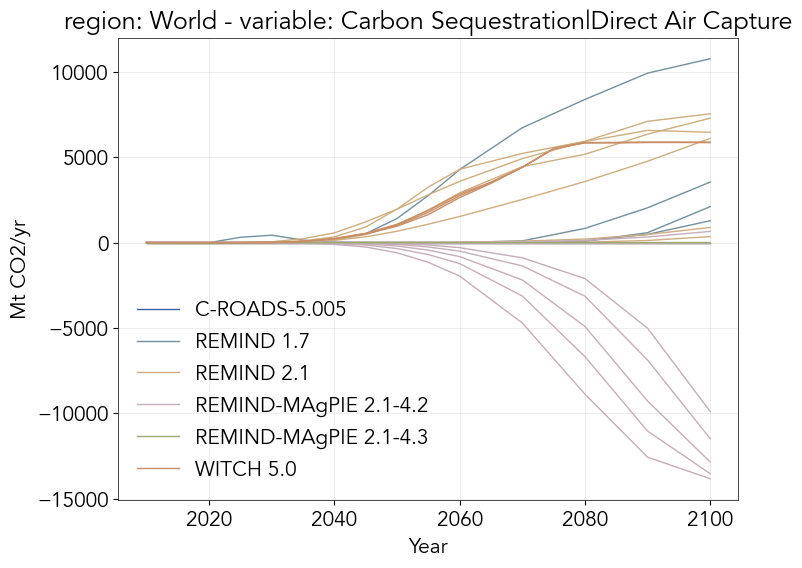

In [32]:
df_c1_nzero.filter(
    variable = "Carbon Sequestration|Direct Air Capture"
).plot(color = "model")

In [33]:
dac_remind = df_c1_nzero.filter(
    model = "REMIND-MAgPIE 2.1-4.2", 
    variable = "Carbon Sequestration|Direct Air Capture", 
    scenario = "EN*",
    region = "World"
)

<Axes: title={'center': 'model: REMIND-MAgPIE 2.1-4.2 - region: World - variable: Carbon Sequestration|Direct Air Capture'}, xlabel='Year', ylabel='Mt CO2/yr'>

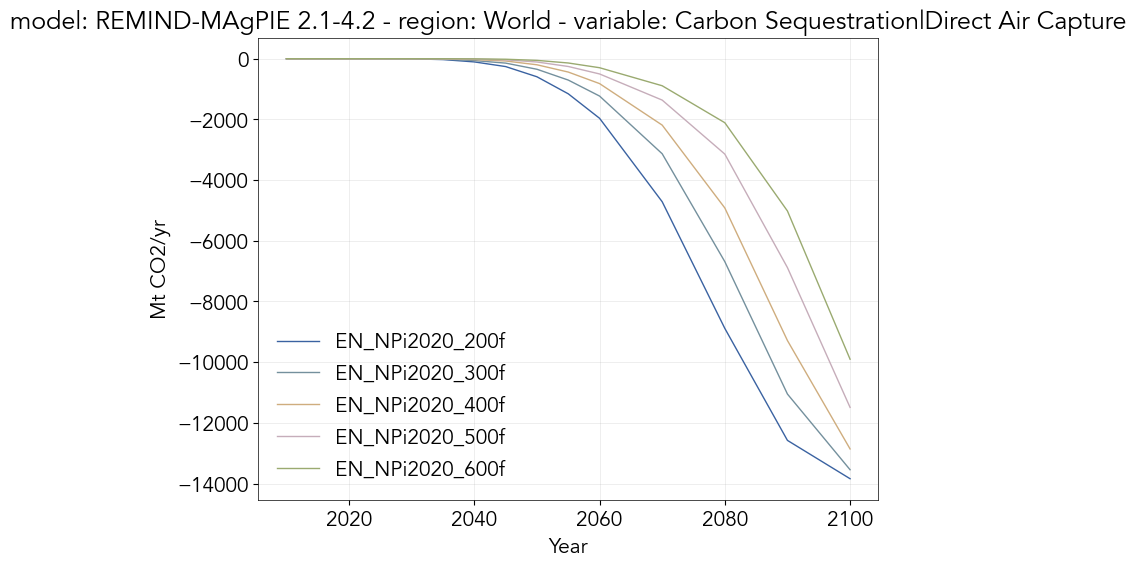

In [34]:
dac_remind.plot()

In [35]:
dac_remind.convert_unit(
    current = "Mt CO2/yr", 
    to = "Mt CO2/yr", 
    factor = -1, 
    inplace = True
)

In [36]:
df_c1_nzero.filter(
    model = "REMIND-MAgPIE 2.1-4.2", 
    scenario = "EN*",
    variable = "Carbon Sequestration|Direct Air Capture", 
    keep = False, 
    inplace = True
)

In [37]:
df_c1_nzero.append(
    dac_remind, 
    inplace = True
)

In [38]:
df_c1_nzero.aggregate(
    variable = "Carbon Dioxide Removal",
    components = [ 
        "Carbon Sequestration|CCS|Biomass",
        "Carbon Sequestration|AFOLU",
        "Carbon Sequestration|Direct Air Capture",
        "Carbon Sequestration|Enhanced Weathering"
    ],
    append = True
)

In [39]:
df_c1_nzero.filter(
    category_new_rolling_mean="PA (Art 2 and 4)"
).require_data("Carbon Dioxide Removal")

model                   scenario                  region
0             AIM/CGE 2.1       CD-LINKS_NPi2020_400  Carbon Dioxide Removal
1      AIM/Hub-Global 2.0                       1.5C  Carbon Dioxide Removal
2           C-ROADS-5.005    Ratchet-1.5-limCDR-noOS  Carbon Dioxide Removal
3               IMAGE 3.2         SSP1_SPA1_19I_D_LB  Carbon Dioxide Removal
4               IMAGE 3.2           SSP1_SPA1_19I_LI  Carbon Dioxide Removal
5               IMAGE 3.2      SSP1_SPA1_19I_LIRE_LB  Carbon Dioxide Removal
6               IMAGE 3.2        SSP1_SPA1_19I_RE_LB  Carbon Dioxide Removal
7               IMAGE 3.2            SSP2_SPA2_19I_D  Carbon Dioxide Removal
8               IMAGE 3.2           SSP2_SPA2_19I_LI  Carbon Dioxide Removal
9               IMAGE 3.2         SSP2_SPA2_19I_LIRE  Carbon Dioxide Removal
10    MESSAGE-GLOBIOM 1.0                    SSP2-19  Carbon Dioxide Removal
11          POLES ADVANCE     ADVANCE_2020_1.5C-2100  Carbon Dioxide Removal
12            POLES EMF33          EMF33_WB2C_nofuel  Carbon Dioxide Removal
13             REMIND 1.7     ADVANCE_2020_1.5C-2100  Carbon Dioxide Removal
14             REMIND 1.7           CEMICS-1.5-CDR12  Carbon Dioxide Removal
15             REMIND 1.7           CEMICS-1.5-CDR20  Carbon Dioxide Removal
16             REMIND 1.7            CEMICS-1.5-CDR8  Carbon Dioxide Removal
17             REMIND 2.1       CEMICS_GDPgrowth_1p5  Carbon Dioxide Removal
18             REMIND 2.1  CEMICS_HotellingConst_1p5  Carbon Dioxide Removal
19             REMIND 2.1          CEMICS_Linear_1p5  Carbon Dioxide Removal
20             REMIND 2.1        R2p1_SSP1-PkBudg900  Carbon Dioxide Removal
21             REMIND 2.1        R2p1_SSP5-PkBudg900  Carbon Dioxide Removal
22      REMIND-MAgPIE 1.5                    SSP2-19  Carbon Dioxide Removal
23  REMIND-MAgPIE 1.7-3.0       CD-LINKS_NPi2020_400  Carbon Dioxide Removal
24  REMIND-MAgPIE 1.7-3.0          EMF33_1.5C_nofuel  Carbon Dioxide Removal
25  REMIND-MAgPIE 1.7-3.0          PEP_1p5C_full_eff  Carbon Dioxide Removal
26  REMIND-MAgPIE 1.7-3.0           PEP_1p5C_red_eff  Carbon Dioxide Removal
27  REMIND-MAgPIE 2.1-4.2   CEMICS_SSP1-1p5C-fullCDR  Carbon Dioxide Removal
28  REMIND-MAgPIE 2.1-4.2      SusDev_SDP-PkBudg1000  Carbon Dioxide Removal
29  REMIND-MAgPIE 2.1-4.2      SusDev_SSP1-PkBudg900  Carbon Dioxide Removal
30  REMIND-MAgPIE 2.1-4.3  DeepElec_SSP2_def_Budg900  Carbon Dioxide Removal
31      WITCH-GLOBIOM 3.1                    SSP4-19  Carbon Dioxide Removal
32      WITCH-GLOBIOM 4.4      CD-LINKS_NPi2020_1000  Carbon Dioxide Removal
33      WITCH-GLOBIOM 4.4       CD-LINKS_NPi2020_400  Carbon Dioxide Removal

# Assign native model net zero years

In [40]:
def _cross_threshold(x):
    y = pyam.timeseries.cross_threshold(x, threshold=0.1)
    # set threshold slightly above 0 to catch convergence to 0
    return y[0] if len(y) else 2101 #I adapt this to 2101 to catch the >2100 explicitly

def calculate_netzero(_df):
    return _df.apply(_cross_threshold, raw=False, axis=1)

In [41]:
co2 = (
    df_c1_nzero
    .filter(variable = "Emissions|CO2")
    .timeseries()
)

In [42]:
df_c1_nzero.set_meta(
    calculate_netzero(co2),
    "netzero|CO2"
)

/Users/gauravganti/anaconda3/envs/scenario_categorisation/lib/python3.10/site-packages/pyam/core.py:897: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  self.meta[name] = meta[name].combine_first(self.meta[name])


In [43]:
df_c1_nzero.filter(
    year = range(2010, 2105, 5),
    inplace = True
)

In [44]:
df_c1_nzero.interpolate(
    time = range(2010, 2105, 5),
    inplace = True
)

pyam.plotting - INFO: >=13 labels, not applying legend


<Axes: title={'center': 'region: World - variable: Emissions|KyotoGHG|excl. CO2'}, xlabel='Year', ylabel='Mt CO2/yr'>

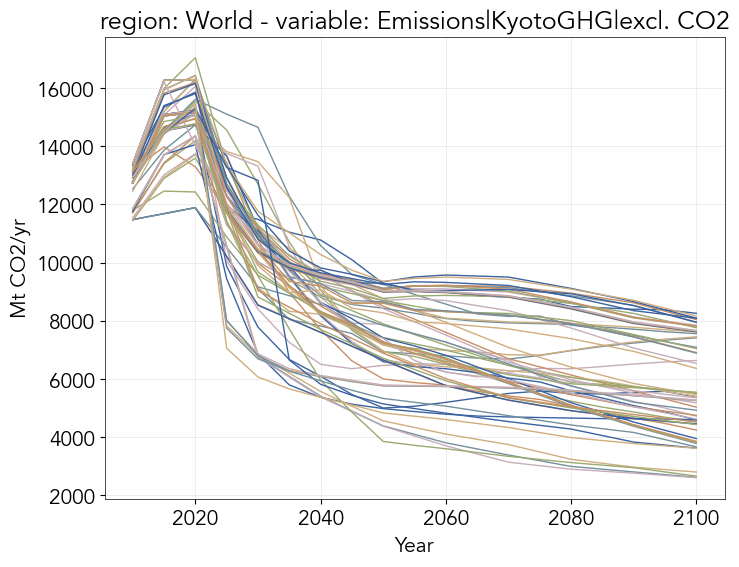

In [45]:
df_c1_nzero.filter(
    variable = "Emissions|KyotoGHG|excl. CO2"
).plot()

In [46]:
df_c1_nzero.aggregate(
    variable = "Emissions|Kyoto Gases|Composite",
    components = [
        "Emissions|CO2",
        "Emissions|KyotoGHG|excl. CO2"
    ],
    append = True
)

In [47]:
kyoto_gases = (
    df_c1_nzero
    .filter(variable = "Emissions|Kyoto Gases|Composite")
    .timeseries()
)

In [48]:
df_c1_nzero.set_meta(
    calculate_netzero(kyoto_gases),
    "netzero|kyotoghg|composite"
)

/Users/gauravganti/anaconda3/envs/scenario_categorisation/lib/python3.10/site-packages/pyam/core.py:897: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  self.meta[name] = meta[name].combine_first(self.meta[name])


In [49]:
df_c1_nzero.set_meta(
    meta = False,
    name = "netzero_composite"
)

In [50]:
df_c1_nzero.set_meta(
    df_c1_nzero.meta.apply(
        lambda x: True if x["netzero|kyotoghg|composite"] < 2100 else False,
        axis = 1
    ),
    name = "netzero_composite"
)

In [51]:
df_c1_nzero.filter(
    netzero_composite = False,
    keep = False, 
    inplace = True
)

# Level calculation
## CDR at net zero CO2
### Step 1: Calculate the level at net zero CO2
I apply a variation of the function [here](https://data.ene.iiasa.ac.at/sr15_scenario_analysis/assessment/sr15_2.0_categories_indicators.html)

In [52]:
def get_from_meta_column(df, x, col):
    val = df.meta.loc[x.name[0:2], col]
    return val if val < 2101 else 2100

In [53]:
cdr = (
    df_c1_nzero
    .filter(
        variable = "Carbon Dioxide Removal"
    )
    .interpolate(range(2020,2101))
    .timeseries()
)

In [54]:
df_c1_nzero.set_meta(
    name = "CDR|level|netzeroCO2", 
    meta = cdr.apply(
        lambda x: x[get_from_meta_column(df_c1_nzero, x, "netzero|CO2")], 
        axis = 1
    )
)

### Step 2: Calculate the cumulative amount till net zero GHG assuming a constant level

In [55]:
df_c1_nzero.set_meta(
    df_c1_nzero.meta.apply(
        lambda x: x["CDR|level|netzeroCO2"] * (x["netzero|kyotoghg|composite"] - x["netzero|CO2"]), 
        axis=1
    ), 
    name = "Cumulative|CDR|CO2|netzeroCO2-netzeroKyotoGHG|Constant Level"
)

# CDR for kyoto greenhouse gases

In [56]:
kyoto_gases_excl_co2 = (
    df_c1_nzero
    .filter(variable = "Emissions|KyotoGHG|excl. CO2")
    .timeseries()
)

In [57]:
df_c1_nzero.set_meta(
    kyoto_gases_excl_co2.apply(
        lambda x: pyam.timeseries.cumulative(
            x, 
            first_year = get_from_meta_column(df_c1_nzero, x, "netzero|CO2"), 
            last_year = get_from_meta_column(df_c1_nzero, x, "netzero|kyotoghg|composite"), 
        ), 
        axis=1
    ), 
    name = "Cumulative|CDR|KyotoGHG|netzeroCO2-netzeroGHG"
)

# Total CDR deployed

In [58]:
cdr = (
    df_c1_nzero
    .filter(variable = "Carbon Dioxide Removal")
    .timeseries()
)

In [59]:
df_c1_nzero.set_meta(
    cdr.apply(
        lambda x: pyam.timeseries.cumulative(
            x, 
            first_year = get_from_meta_column(df_c1_nzero, x, "netzero|CO2"), 
            last_year = get_from_meta_column(df_c1_nzero, x, "netzero|kyotoghg|composite")
        ), 
        axis=1
    ), 
    name = "Cumulative|CDR|netzeroCO2-netzeroGHG"
)

In [60]:
df_c1_nzero.set_meta(
    df_c1_nzero.meta.apply(
        lambda x: x["Cumulative|CDR|netzeroCO2-netzeroGHG"] - (x["Cumulative|CDR|KyotoGHG|netzeroCO2-netzeroGHG"] + x["Cumulative|CDR|CO2|netzeroCO2-netzeroKyotoGHG|Constant Level"]), 
        axis = 1
    ), 
    name = "Delta|CDR|netzeroCO2-netzeroGHG"
)

Now, we add this to the cumulative estimate to "correct" the constant level assumption.

In [61]:
df_c1_nzero.set_meta(
    df_c1_nzero.meta.apply(
        lambda x: x["Cumulative|CDR|CO2|netzeroCO2-netzeroKyotoGHG|Constant Level"] + x["Delta|CDR|netzeroCO2-netzeroGHG"], 
        axis = 1   
    ), 
    name = "Cumulative|CDR|CO2|netzeroCO2-netzeroGHG|Corrected"
)

We calculate a new average level over the period to propagate forward.

In [62]:
df_c1_nzero.set_meta(
    df_c1_nzero.meta.apply(
        lambda x: x["Cumulative|CDR|CO2|netzeroCO2-netzeroGHG|Corrected"] / (x["netzero|kyotoghg|composite"] - x["netzero|CO2"]), 
        axis = 1   
    ), 
    name = "CDR|level|CO2|netzeroGHG"
)

In [63]:
df_c1_nzero.meta[["CDR|level|netzeroCO2", "CDR|level|CO2|netzeroGHG"]].describe()

CDR|level|netzeroCO2  CDR|level|CO2|netzeroGHG
count             59.000000                 59.000000
mean            9186.028053               4536.496154
std             2840.677222               3094.194883
min             3613.439350                299.779561
25%             6639.976655               1757.357144
50%             9266.131542               4427.537954
75%            11206.471730               6769.454721
max            15695.807001              12654.803290

# Now to the end of century..

In [64]:
df_c1_nzero.set_meta(
    df_c1_nzero.meta.apply(
        lambda x: x["CDR|level|CO2|netzeroGHG"] * (2100 - x["netzero|kyotoghg|composite"]), 
        axis=1
    ), 
    name = "Cumulative|CDR|CO2|netzeroKyotoGHG-2100|Constant Level"
)

In [65]:
df_c1_nzero.set_meta(
    kyoto_gases_excl_co2.apply(
        lambda x: pyam.timeseries.cumulative(
            x, 
            first_year = get_from_meta_column(df_c1_nzero, x, "netzero|kyotoghg|composite"), 
            last_year = 2100
        ), 
        axis=1
    ), 
    name = "Cumulative|CDR|KyotoGHG|netzeroGHG-2100"
)

In [66]:
df_c1_nzero.set_meta(
    cdr.apply(
        lambda x: pyam.timeseries.cumulative(
            x, 
            first_year = get_from_meta_column(df_c1_nzero, x, "netzero|kyotoghg|composite"),
            last_year = 2100
        ), 
        axis=1
    ), 
    name = "Cumulative|CDR|netzeroGHG-2100"
)

In [67]:
df_c1_nzero.set_meta(
    df_c1_nzero.meta.apply(
        lambda x: x["Cumulative|CDR|netzeroGHG-2100"] - (x["Cumulative|CDR|KyotoGHG|netzeroGHG-2100"] + x["Cumulative|CDR|CO2|netzeroKyotoGHG-2100|Constant Level"]), 
        axis = 1
    ), 
    name = "Delta|CDR|netzeroGHG-2100"
)

In [68]:
## Additional assumptions
df_c1_nzero.set_meta(
    df_c1_nzero.meta.apply(
        lambda x: x["Delta|CDR|netzeroGHG-2100"] if x["Delta|CDR|netzeroGHG-2100"] > 0 else 0, 
        axis = 1
    ), 
    name = "Amount|CDR|Additional Assumptions"
)

In [69]:
df_c1_nzero.set_meta(
    df_c1_nzero.meta.apply(
        lambda x: 100 *  x["Delta|CDR|netzeroGHG-2100"] / (x["Cumulative|CDR|netzeroCO2-netzeroGHG"] + x["Cumulative|CDR|netzeroGHG-2100"]) if x["Delta|CDR|netzeroGHG-2100"] > 0 else 0, 
        axis = 1
    ), 
    name = "Proportion|CDR|Additional Assumptions"
)

In [70]:
## CDR for KyotoGHG
df_c1_nzero.set_meta(
    df_c1_nzero.meta.apply(
        lambda x: x["Cumulative|CDR|KyotoGHG|netzeroGHG-2100"] + x["Cumulative|CDR|KyotoGHG|netzeroCO2-netzeroGHG"], 
        axis = 1
    ), 
    name = "Amount|CDR|KyotoGHG"
)

In [71]:
df_c1_nzero.set_meta(
    df_c1_nzero.meta.apply(
        lambda x: 100 * (x["Cumulative|CDR|KyotoGHG|netzeroGHG-2100"] + x["Cumulative|CDR|KyotoGHG|netzeroCO2-netzeroGHG"]) / (x["Cumulative|CDR|netzeroCO2-netzeroGHG"] + x["Cumulative|CDR|netzeroGHG-2100"]), 
        axis = 1
    ), 
    name = "Proportion|CDR|KyotoGHG"
)

In [72]:
## CDR for CO2
df_c1_nzero.set_meta( 
    df_c1_nzero.meta.apply(
        lambda x: x["Cumulative|CDR|CO2|netzeroCO2-netzeroGHG|Corrected"] + x["Cumulative|CDR|CO2|netzeroKyotoGHG-2100|Constant Level"]
        if x["Delta|CDR|netzeroGHG-2100"] > 0 
        else x["Cumulative|CDR|CO2|netzeroCO2-netzeroGHG|Corrected"] + x["Cumulative|CDR|CO2|netzeroKyotoGHG-2100|Constant Level"] , 
        axis = 1
    ), 
    name = "Amount|CDR|CO2"    
)

In [73]:
df_c1_nzero.set_meta(
    df_c1_nzero.meta.apply(
        lambda x: 100 * (x["Cumulative|CDR|CO2|netzeroCO2-netzeroGHG|Corrected"] + x["Cumulative|CDR|CO2|netzeroKyotoGHG-2100|Constant Level"]) / (x["Cumulative|CDR|netzeroCO2-netzeroGHG"] + x["Cumulative|CDR|netzeroGHG-2100"])
        if x["Delta|CDR|netzeroGHG-2100"] > 0 
        else 100 * (x["Cumulative|CDR|CO2|netzeroCO2-netzeroGHG|Corrected"] + x["Cumulative|CDR|CO2|netzeroKyotoGHG-2100|Constant Level"] + x["Delta|CDR|netzeroGHG-2100"]) / (x["Cumulative|CDR|netzeroCO2-netzeroGHG"] + x["Cumulative|CDR|netzeroGHG-2100"]), 
        axis = 1
    ), 
    name = "Proportion|CDR|CO2"
)

In [74]:
data_fig5 = df_c1_nzero.filter(
    category_new_rolling_mean = "PA (Art 2 and 4)"
).meta

In [75]:
data_fig5

Category  \
model                 scenario                             
AIM/CGE 2.1           CD-LINKS_NPi2020_400            C1   
AIM/Hub-Global 2.0    1.5C                            C1   
C-ROADS-5.005         Ratchet-1.5-limCDR-noOS         C1   
IMAGE 3.2             SSP1_SPA1_19I_D_LB              C1   
                      SSP1_SPA1_19I_LI                C2   
                      SSP1_SPA1_19I_LIRE_LB           C1   
                      SSP1_SPA1_19I_RE_LB             C1   
                      SSP2_SPA2_19I_D                 C2   
                      SSP2_SPA2_19I_LI                C1   
                      SSP2_SPA2_19I_LIRE              C2   
MESSAGE-GLOBIOM 1.0   SSP2-19                         C1   
POLES ADVANCE         ADVANCE_2020_1.5C-2100          C1   
POLES EMF33           EMF33_WB2C_nofuel               C1   
REMIND 1.7            ADVANCE_2020_1.5C-2100          C1   
                      CEMICS-1.5-CDR12                C1   
                      CEMICS-1.5-CDR20                C1   
REMIND 2.1            CEMICS_GDPgrowth_1p5            C1   
                      CEMICS_HotellingConst_1p5       C1   
                      CEMICS_Linear_1p5               C1   
                      R2p1_SSP1-PkBudg900             C1   
                      R2p1_SSP5-PkBudg900             C1   
REMIND-MAgPIE 1.5     SSP2-19                         C1   
REMIND-MAgPIE 1.7-3.0 CD-LINKS_NPi2020_400            C1   
                      EMF33_1.5C_nofuel               C1   
                      PEP_1p5C_full_eff               C1   
REMIND-MAgPIE 2.1-4.2 CEMICS_SSP1-1p5C-fullCDR        C1   
                      SusDev_SDP-PkBudg1000           C1   
                      SusDev_SSP1-PkBudg900           C1   
REMIND-MAgPIE 2.1-4.3 DeepElec_SSP2_def_Budg900       C1   
WITCH-GLOBIOM 3.1     SSP4-19                         C1   
WITCH-GLOBIOM 4.4     CD-LINKS_NPi2020_1000           C1   
                      CD-LINKS_NPi2020_400            C1   

                                                                                     Category_name  \
model                 scenario                                                                       
AIM/CGE 2.1           CD-LINKS_NPi2020_400       C1: limit warming to 1.5°C (>50%) with no or l...   
AIM/Hub-Global 2.0    1.5C                       C1: limit warming to 1.5°C (>50%) with no or l...   
C-ROADS-5.005         Ratchet-1.5-limCDR-noOS    C1: limit warming to 1.5°C (>50%) with no or l...   
IMAGE 3.2             SSP1_SPA1_19I_D_LB         C1: limit warming to 1.5°C (>50%) with no or l...   
                      SSP1_SPA1_19I_LI           C2: return warming to 1.5°C (>50%) after a hig...   
                      SSP1_SPA1_19I_LIRE_LB      C1: limit warming to 1.5°C (>50%) with no or l...   
                      SSP1_SPA1_19I_RE_LB        C1: limit warming to 1.5°C (>50%) with no or l...   
                      SSP2_SPA2_19I_D            C2: return warming to 1.5°C (>50%) after a hig...   
                      SSP2_SPA2_19I_LI           C1: limit warming to 1.5°C (>50%) with no or l...   
                      SSP2_SPA2_19I_LIRE         C2: return warming to 1.5°C (>50%) after a hig...   
MESSAGE-GLOBIOM 1.0   SSP2-19                    C1: limit warming to 1.5°C (>50%) with no or l...   
POLES ADVANCE         ADVANCE_2020_1.5C-2100     C1: limit warming to 1.5°C (>50%) with no or l...   
POLES EMF33           EMF33_WB2C_nofuel          C1: limit warming to 1.5°C (>50%) with no or l...   
REMIND 1.7            ADVANCE_2020_1.5C-2100     C1: limit warming to 1.5°C (>50%) with no or l...   
                      CEMICS-1.5-CDR12           C1: limit warming to 1.5°C (>50%) with no or l...   
                      CEMICS-1.5-CDR20           C1: limit warming to 1.5°C (>50%) with no or l...   
REMIND 2.1            CEMICS_GDPgrowth_1p5       C1: limit warming to 1.5°C (>50%) with no or l...   
                      CEMICS_HotellingConst_1p5  C1: limit warming to

In [76]:
data_fig5["Total CDR"] = (
    data_fig5["Amount|CDR|CO2"]
    +
    data_fig5["Amount|CDR|KyotoGHG"]
    +
    data_fig5["Amount|CDR|Additional Assumptions"]
)

In [77]:
data_fig5 = data_fig5.sort_values(by="Total CDR", ascending=False)

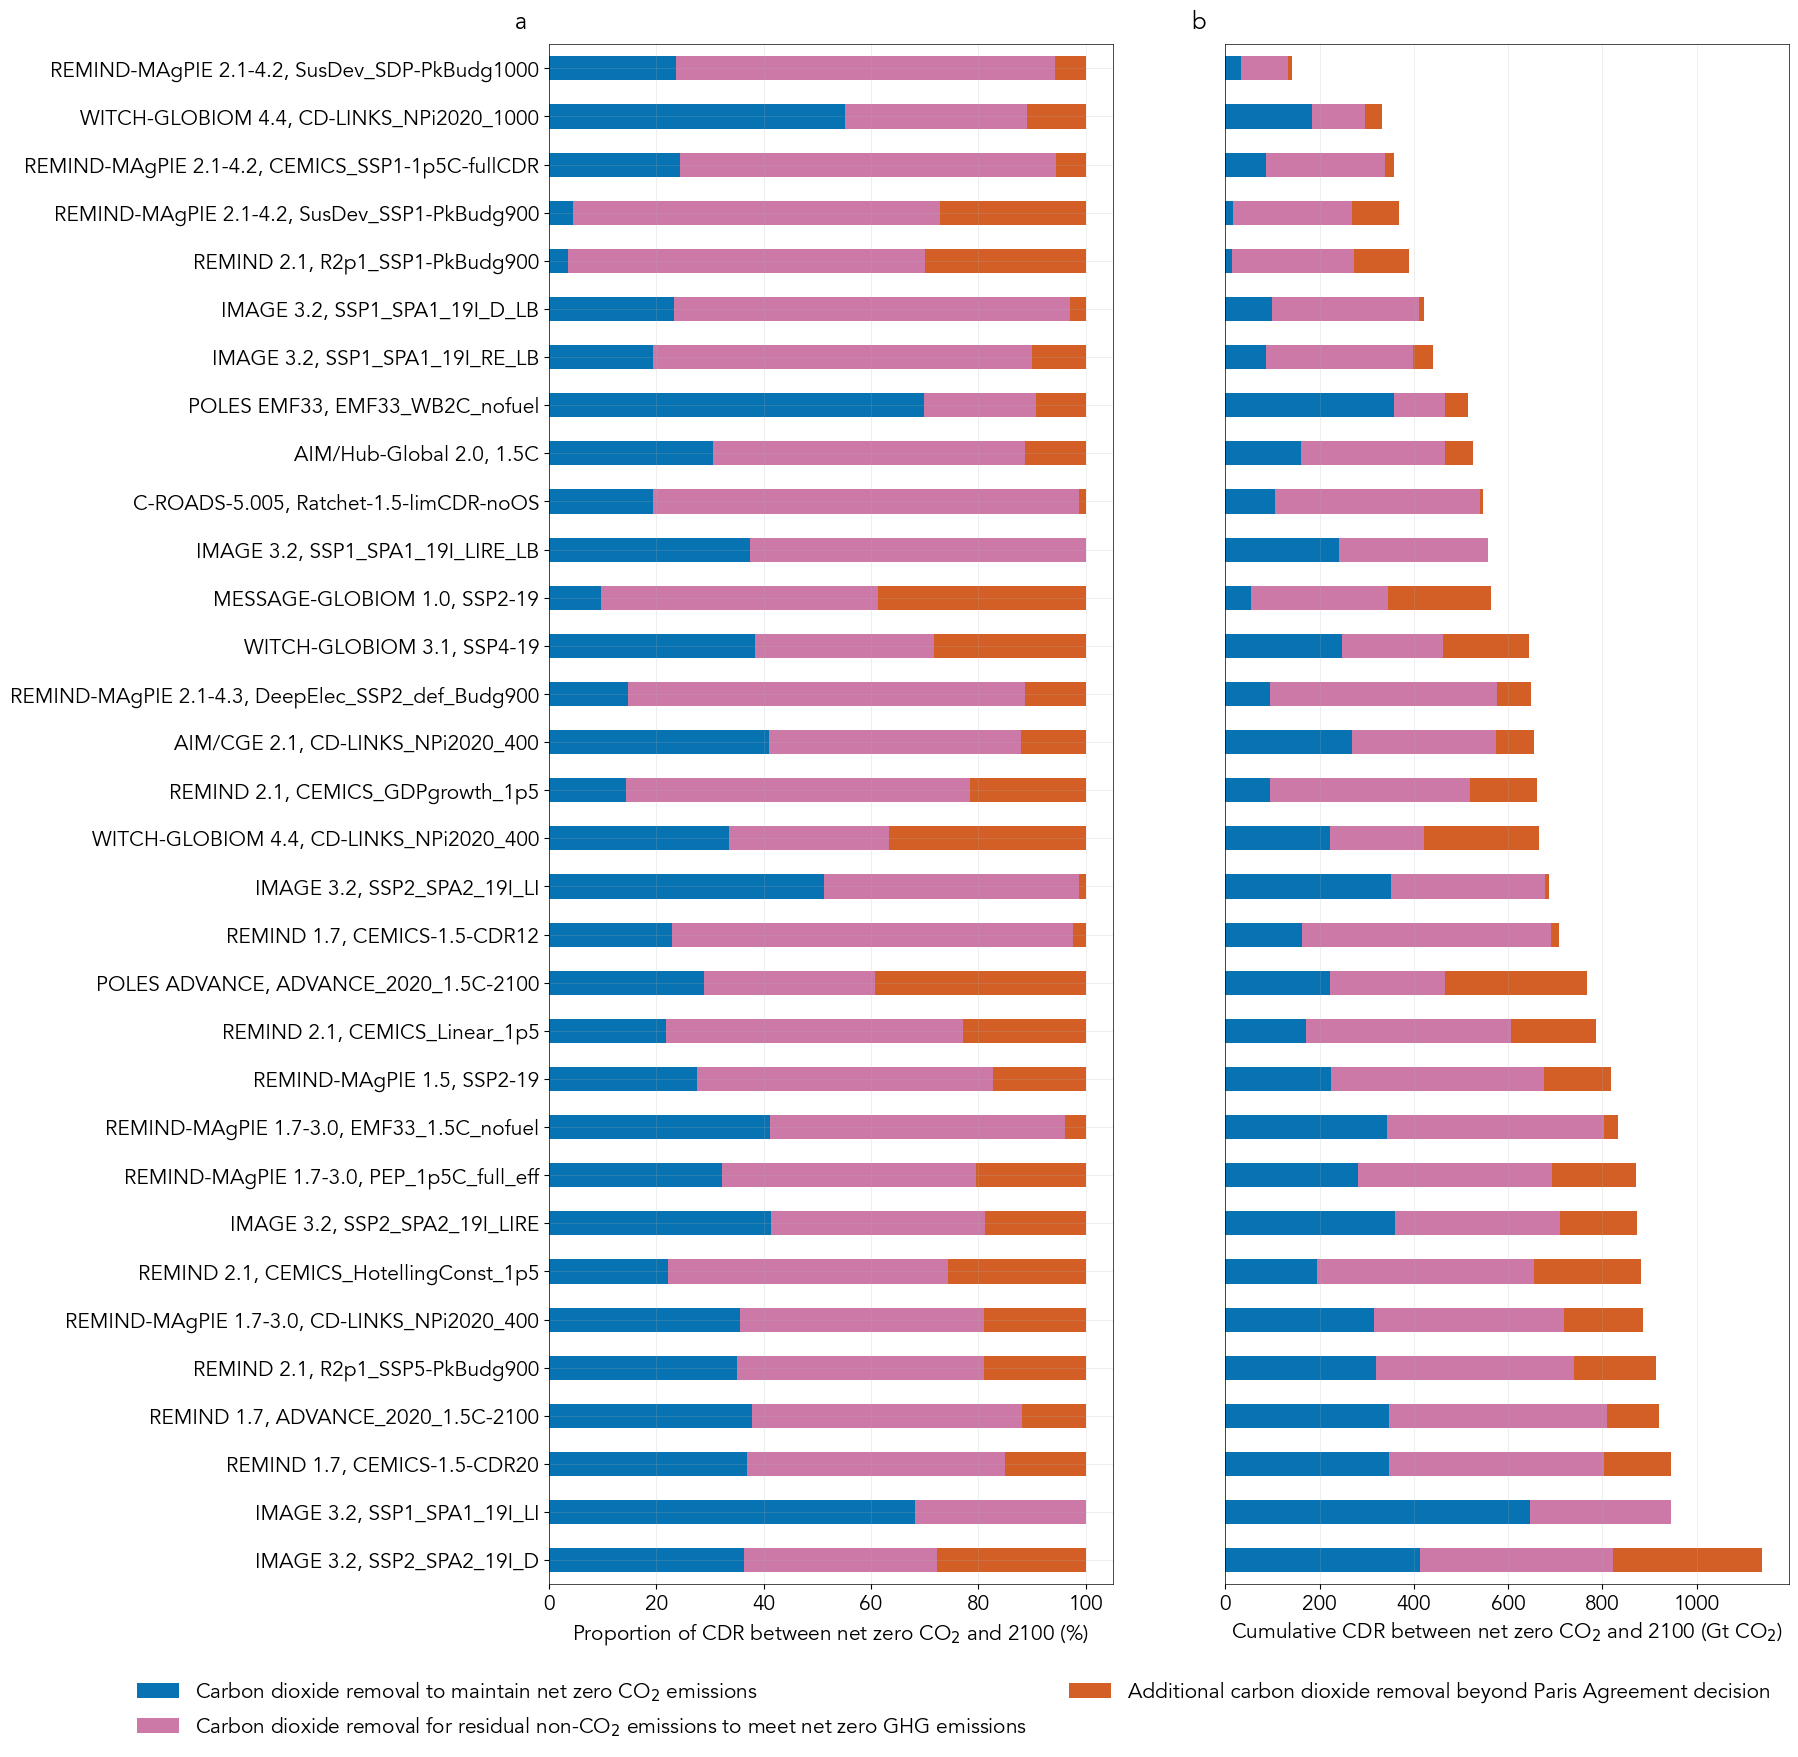

In [78]:
fig, ax = plt.subplots(1,2, figsize=(16,20))
# Panel 1: Waterfall chart
data_fig5[["Proportion|CDR|CO2", "Proportion|CDR|KyotoGHG", "Proportion|CDR|Additional Assumptions"]].plot.barh(
    stacked=True, 
    ax=ax[0], 
    color=["#0773b2",  "#cc79a7", "#d35f27"]
)
ax[0].set_ylabel("")
ax[0].set_xlabel("Proportion of CDR between net zero CO$_2$ and 2100 (%)")

(data_fig5[["Amount|CDR|CO2", "Amount|CDR|KyotoGHG", "Amount|CDR|Additional Assumptions"]]/1e3).plot.barh(
    stacked=True, ax=ax[1], color=["#0773b2",  "#cc79a7", "#d35f27"])

ax[1].set_yticks([])
ax[1].set_xlabel("Cumulative CDR between net zero CO$_2$ and 2100 (Gt CO$_2$)")
ax[1].set_ylabel("")

# Annotations
for n,a in enumerate(ax):
    a.text(
        -0.06, 1.01, 
        string.ascii_lowercase[n], 
        transform=a.transAxes,
        size=17, 
        weight='bold'
    )
    a.get_legend().remove()

# Custom legend 
legend_handles = [ 
    Patch(facecolor = "#0773b2", label = "Carbon dioxide removal to maintain net zero CO$_2$ emissions"), 
    Patch(facecolor = "#cc79a7", label = "Carbon dioxide removal for residual non-CO$_2$ emissions to meet net zero GHG emissions"), 
    Patch(facecolor = "#d35f27", label = "Additional carbon dioxide removal beyond Paris Agreement decision")
]

# Alter tick labels
labels = [item.get_text() for item in ax[0].get_yticklabels()]
labels_new = [s.replace("(", "").replace(")", "") for s in labels]
ax[0].set_yticklabels(labels_new)

ax[1].legend(
    handles = legend_handles, 
    bbox_to_anchor = (1, -0.05), ncol=2
)

In [79]:
fig.savefig(
    Path("figures/Figure 5.png"),
    dpi = 1000
)

In [80]:
data_fig5[ 
    [ 
        "Proportion|CDR|CO2", 
        "Proportion|CDR|KyotoGHG", 
        "Proportion|CDR|Additional Assumptions",
        "Amount|CDR|CO2", 
        "Amount|CDR|KyotoGHG", 
        "Amount|CDR|Additional Assumptions"
    ]
].describe().T.to_excel(
    Path("tables/Table_for_Fig5.xlsx")
)

# Additional information across the whole ensemble of low and no OS.

In [81]:
data_additional_table = df_c1_nzero.meta

In [82]:
data_additional_table[ 
    [ 
        "Proportion|CDR|CO2", 
        "Proportion|CDR|KyotoGHG", 
        "Proportion|CDR|Additional Assumptions",
        "Amount|CDR|CO2", 
        "Amount|CDR|KyotoGHG", 
        "Amount|CDR|Additional Assumptions"
    ]
].describe().T.to_excel(
    Path("tables/Table_for_Fig5_whole_ensemble.xlsx")
)

In [83]:
data_fig5['Proportion|CDR|Additional Assumptions'].describe().round(0)

count    32.0
mean     16.0
std      12.0
min       0.0
25%       6.0
50%      14.0
75%      24.0
max      39.0
Name: Proportion|CDR|Additional Assumptions, dtype: float64